In [3]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
# data = nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii')
# img = np.asarray(data.dataobj)
# print(img.shape, np.unique(img))
# img = ((img - img.min ())/(img.max () - img.min ()) * 255).astype(np.uint8)

# image = img.copy()
# image = (image / 255 * 4).round ()
# # image [image == 3] = 4
# print(image.shape, np.unique(image))
# mask=image
# mask_WT = np.zeros(mask.shape)
# mask_WT[mask == 2] = 1

# mask_TC = np.zeros(mask.shape)
# mask_TC[mask == 1] = 1

# mask_ET = np.zeros(mask.shape)
# mask_ET[mask == 3] = 1

# mask_BG = np.zeros(mask.shape)
# mask_BG[mask == 0] = 1
        
# mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
# print(mask.shape)

# mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

# print(mask.shape)
# # np.unique(data)
# # mask_WT = mask.copy()
# # mask_WT[mask_WT == 1] = 1
# # mask_WT[mask_WT == 2] = 1
# # mask_WT[mask_WT == 4] = 1

# # mask_TC = mask.copy()
# # mask_TC[mask_TC == 1] = 1
# # mask_TC[mask_TC == 2] = 0
# # mask_TC[mask_TC == 4] = 1

# # mask_ET = mask.copy()
# # mask_ET[mask_ET == 1] = 0
# # mask_ET[mask_ET == 2] = 0
# # mask_ET[mask_ET == 4] = 1

# # mask = np.stack([mask_WT, mask_TC, mask_ET])
# # mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

In [5]:
class Configurations:

    #trying to contain all the paths here
    dest_path = '../input/brats20-dataset-training-validation'
    train_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_path = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    
    
    path_to_csv = './train_data.csv'
    pretrained_model_path = '../input/brats20logs/brats2020logs/unet/last_epoch_model.pth'
    train_logs_path = '../input/brats20logs/brats2020logs/unet/train_log.csv'
    ae_pretrained_model_path = '../input/brats20logs/brats2020logs/ae/autoencoder_best_model.pth'
    tab_data = '../input/brats20logs/brats2020logs/data/df_with_voxel_stats_and_latent_features.csv'
    seed = 55
    
def seedlings(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Configurations()
seedlings(config.seed)

In [10]:
survival_info_df = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

# Rename the column
name_mapping_df = name_mapping_df.rename(columns={'BraTS_2020_subject_ID': 'Brats20ID'})

# Merge the dataframes
df = pd.merge(survival_info_df, name_mapping_df, on="Brats20ID", how="right")


# Generate pathways based on phase
df['path'] = df['Brats20ID'].apply(
    lambda id_: os.path.join(config.train_path, id_) if "Training" in id_.split("_")[-2] 
    else os.path.join(config.test_path, id_)
)

# Filter training data and preprocess
train_data = df[df['Age'].notnull()].reset_index(drop=True)
train_data['Age_rank'] = (train_data['Age'] // 10) * 10
train_data = train_data[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True)

# Stratified K-Fold split
skf = StratifiedKFold(n_splits=7, random_state=config.seed, shuffle=True)
train_data['fold'] = -1  # Initialize fold column

for fold, (_, val_index) in enumerate(skf.split(train_data, train_data['Age_rank'])):
    train_data.loc[val_index, 'fold'] = fold

# Split into training and validation datasets
train_df = train_data[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data[train_data['fold'] == 0].reset_index(drop=True)

# Create test dataset
test_df = df[df['Age'].isnull()].reset_index(drop=True)

# Print dataset shapes
print(f"train_df -> {train_df.shape}, val_df -> {val_df.shape}, test_df -> {test_df.shape}")

# Save train_data to CSV
train_data.to_csv("train_data.csv", index=False)


train_df -> (201, 12), val_df -> (34, 12), test_df -> (133, 10)


In [11]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test", is_resize: bool = False):
        """
        Initializes the BratsDataset.

        Parameters:
        - df (pd.DataFrame): DataFrame containing metadata for the dataset, including file paths and labels.
        - phase (str): The phase of the dataset, either "train", "val", or "test".
        - is_resize (bool): Whether to resize the images and masks.
        """
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)  # Get augmentations for the specified phase.
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']  # Modalities to load.
        self.is_resize = is_resize

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves and preprocesses a single sample.

        Parameters:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - dict: A dictionary containing the ID, image, and (optionally) mask for the sample.
        """
        # Get the unique ID and root path for the sample.
        id_ = self.df.iloc[idx]['Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_, 'path'].values[0]
        
        # Load and preprocess images for all modalities.
        images = self.load_and_preprocess_images(root_path, id_)
        # Stack and rearrange dimensions to match the required format (C, H, W, D).
        images = np.moveaxis(np.stack(images), (0, 1, 2, 3), (0, 3, 2, 1))
        
        # If phase is not "test", load and preprocess the mask.
        if self.phase != "test":
            mask = self.load_and_preprocess_mask(root_path, id_)
            # Apply augmentations to both images and masks.
            augmented = self.augmentations(image=images.astype(np.float32), mask=mask.astype(np.float32))
            return {"Id": id_, "image": augmented['image'], "mask": augmented['mask']}
        
        # For "test" phase, only return the ID and images.
        return {"Id": id_, "image": images}

    def load_img(self, file_path):
        """
        Loads a NIfTI image from the given file path.

        Parameters:
        - file_path (str): Path to the NIfTI file.

        Returns:
        - np.ndarray: Loaded image data.
        """
        return np.asarray(nib.load(file_path).dataobj)

    def normalize(self, data: np.ndarray):
        """
        Normalizes the image data to [0, 1] range.

        Parameters:
        - data (np.ndarray): Image data to normalize.

        Returns:
        - np.ndarray: Normalized image data.
        """
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def resize(self, data: np.ndarray):
        """
        Resizes the image data to a predefined shape.

        Parameters:
        - data (np.ndarray): Image data to resize.

        Returns:
        - np.ndarray: Resized image data.
        """
        return resize(data, (78, 120, 120), preserve_range=True)

    def load_and_preprocess_images(self, root_path, id_):
        """
        Loads and preprocesses images for all modalities.

        Parameters:
        - root_path (str): Root path where the image files are located.
        - id_ (str): Unique ID of the sample.

        Returns:
        - list: List of preprocessed images for each modality.
        """
        images = []
        for data_type in self.data_types:
            # Construct the file path for the modality.
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)
            # Resize and normalize the image if required.
            if self.is_resize:
                img = self.resize(img)
            images.append(self.normalize(img))
        return images

    def load_and_preprocess_mask(self, root_path, id_):
        """
        Loads and preprocesses the mask for the sample.

        Parameters:
        - root_path (str): Root path where the mask file is located.
        - id_ (str): Unique ID of the sample.

        Returns:
        - np.ndarray: Preprocessed mask.
        """
        mask_path = os.path.join(root_path, id_ + "_seg.nii")
        mask = self.load_img(mask_path)
        if self.is_resize:
            mask = self.resize(mask)
            mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
        return self.preprocess_mask_labels(mask)

    def preprocess_mask_labels(self, mask: np.ndarray):
        """
        Preprocesses mask labels to create WT, TC, and ET masks.

        Parameters:
        - mask (np.ndarray): Original mask.

        Returns:
        - np.ndarray: Stacked and processed mask with WT, TC, and ET labels.
        """
        masks = {
            "WT": (mask == 1) | (mask == 2) | (mask == 4),  # Whole Tumor
            "TC": (mask == 1) | (mask == 4),               # Tumor Core
            "ET": (mask == 4)                              # Enhancing Tumor
        }
        # Stack masks and rearrange dimensions to match the required format.
        stacked_mask = np.stack([masks["WT"], masks["TC"], masks["ET"]])
        return np.moveaxis(stacked_mask, (0, 1, 2, 3), (0, 3, 2, 1))


In [16]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4,
    is_resize = False,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    
    if phase=='test':
        df=df[:22]
    if phase=='test':
        df=df[:4]
        
    dataset = dataset(df, phase, is_resize)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader





In [18]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0, is_resize=True)
len(dataloader)
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape



(['BraTS20_Training_251'],
 torch.Size([1, 4, 120, 120, 78]),
 torch.Size([1, 3, 120, 120, 78]))

 Data insights
Total number of images- unique: 115650
Range( min - max value): 0.0 1.0
Total number of masks - unique : (array([0., 1.], dtype=float32), array([1117546,    5654]))


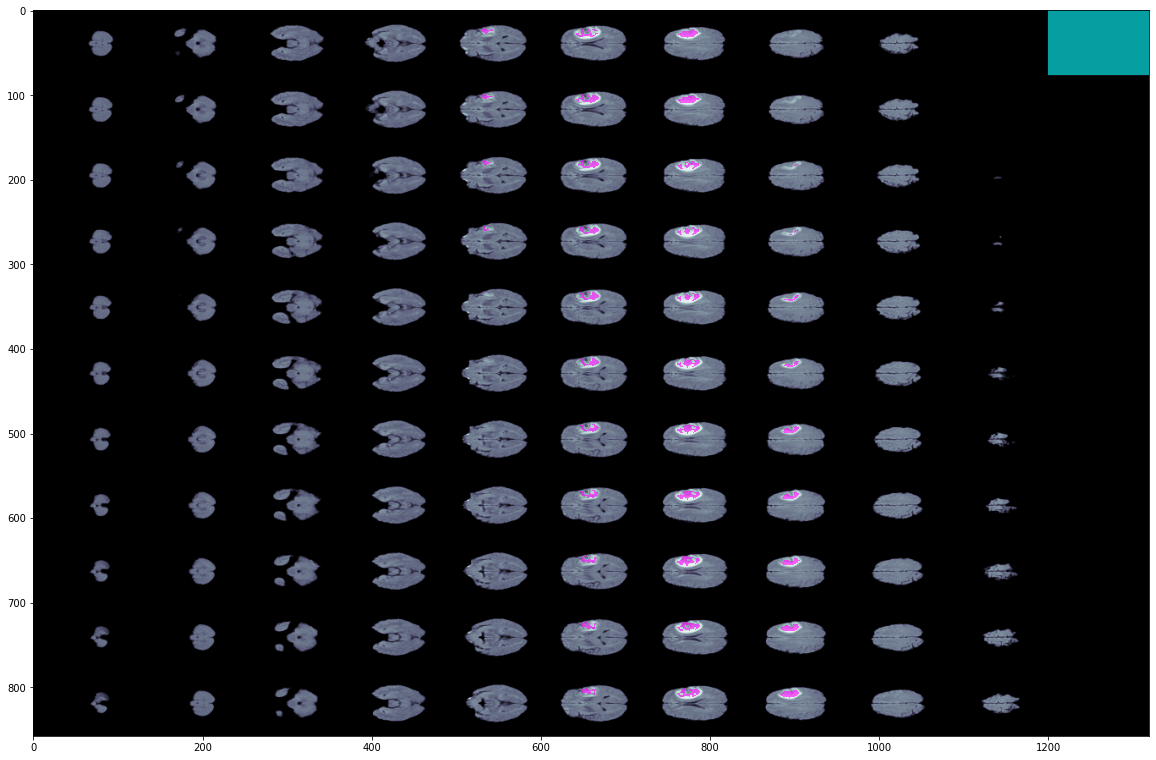

In [22]:
tensor_3dimage = data['image'].squeeze()[0].cpu().detach().numpy() 
tensor_mask = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()

image = np.rot90(montage(tensor_3dimage))
mask = np.rot90(montage(tensor_mask)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

print(" Data insights")
print("Total number of images- unique:", len(np.unique(tensor_3dimage, return_counts=True)[0]))
print("Range( min - max value):", tensor_3dimage.min(), tensor_3dimage.max())
print("Total number of masks - unique :", np.unique(tensor_mask, return_counts=True))



In [23]:
def dice_coef_metric(probabilities: torch.Tensor, truth: torch.Tensor, threshold: float = 0.5, eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for a batch of data.

    Parameters:
    - probabilities: Model outputs after activation function.
    - truth: Ground truth labels.
    - threshold: Threshold for converting probabilities to binary predictions.
    - eps: Small additive constant to avoid division by zero.

    Returns:
    - Dice score (F1-score) as a float.
    """
    scores = []
    num_samples = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()

    assert predictions.shape == truth.shape

    for i in range(num_samples):
        pred = predictions[i]
        true = truth[i]
        intersection = 2.0 * (true * pred).sum()
        union = true.sum() + pred.sum()
        if true.sum() == 0 and pred.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)

    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor, truth: torch.Tensor, threshold: float = 0.5, eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index (IoU) for a batch of data.

    Parameters:
    - probabilities: Model outputs after activation function.
    - truth: Ground truth labels.
    - threshold: Threshold for converting probabilities to binary predictions.
    - eps: Small additive constant to avoid division by zero.

    Returns:
    - Jaccard score (IoU) as a float.
    """
    scores = []
    num_samples = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()

    assert predictions.shape == truth.shape

    for i in range(num_samples):
        pred = predictions[i]
        true = truth[i]
        intersection = (true * pred).sum()
        union = (pred.sum() + true.sum() - intersection + eps)
        if true.sum() == 0 and pred.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)

    return np.mean(scores)


class Meter:
    """
    Class for storing and updating IoU and Dice scores during model evaluation.
    """
    def __init__(self, threshold: float = 0.5):
        self.threshold = threshold
        self.dice_scores = []
        self.iou_scores = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Update Dice and IoU scores with new predictions and targets.

        Parameters:
        - logits: Raw outputs from the model.
        - targets: Ground truth labels.
        """
        probabilities = torch.sigmoid(logits)
        dice = dice_coef_metric(probabilities, targets, self.threshold)
        iou = jaccard_coef_metric(probabilities, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        """
        Compute and return the average Dice and IoU scores.

        Returns:
        - Tuple of average Dice and IoU scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """
    Compute Dice loss for binary segmentation.
    """
    def __init__(self, eps: float = 1e-9):
        super().__init__()
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        num_samples = targets.size(0)
        probabilities = torch.sigmoid(logits).view(num_samples, -1)
        targets = targets.view(num_samples, -1)

        assert probabilities.shape == targets.shape

        intersection = 2.0 * (probabilities * targets).sum()
        union = probabilities.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union

        return 1.0 - dice_score


class BCEDiceLoss(nn.Module):
    """
    Combine BCE loss and Dice loss for segmentation tasks.
    """
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        assert logits.shape == targets.shape
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss


def dice_coef_metric_per_classes(probabilities: np.ndarray, truth: np.ndarray, threshold: float = 0.5, eps: float = 1e-9, classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Compute Dice scores for each class in a batch.

    Parameters:
    - probabilities: Model outputs after activation function.
    - truth: Ground truth labels.
    - threshold: Threshold for converting probabilities to binary predictions.
    - eps: Small additive constant to avoid division by zero.
    - classes: List of class names.

    Returns:
    - Dictionary with Dice scores for each class.
    """
    scores = {key: [] for key in classes}
    num_samples = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= threshold).astype(np.float32)

    assert predictions.shape == truth.shape

    for i in range(num_samples):
        for class_idx in range(num_classes):
            pred = predictions[i][class_idx]
            true = truth[i][class_idx]
            intersection = 2.0 * (pred * true).sum()
            union = pred.sum() + true.sum()
            if true.sum() == 0 and pred.sum() == 0:
                scores[classes[class_idx]].append(1.0)
            else:
                scores[classes[class_idx]].append((intersection + eps) / union)

    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray, truth: np.ndarray, threshold: float = 0.5, eps: float = 1e-9, classes: list = ['WT', 'TC', 'ET']) -> dict:
    """
    Compute Jaccard index (IoU) for each class in a batch.

    Parameters:
    - probabilities: Model outputs after activation function.
    - truth: Ground truth labels.
    - threshold: Threshold for converting probabilities to binary predictions.
    - eps: Small additive constant to avoid division by zero.
    - classes: List of class names.

    Returns:
    - Dictionary with IoU scores for each class.
    """
    scores = {key: [] for key in classes}
    num_samples = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= threshold).astype(np.float32)

    assert predictions.shape == truth.shape

    for i in range(num_samples):
        for class_idx in range(num_classes):
            pred = predictions[i][class_idx]
            true = truth[i][class_idx]
            intersection = (pred * true).sum()
            union = pred.sum() + true.sum() - intersection + eps
            if true.sum() == 0 and pred.sum() == 0:
                scores[classes[class_idx]].append(1.0)
            else:
                scores[classes[class_idx]].append((intersection + eps) / union)

    return scores


In [24]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

In [31]:
class Trainer:
    """
    Factory for training process.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                 is_resize: bool= False,

                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Device: {self.device}")
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.is_resize = is_resize

        self.dataloaders = {
            phase: get_dataloader(
                dataset=dataset,
                path_to_csv=path_to_csv,
                phase=phase,
                fold=fold,
                batch_size=batch_size,
                num_workers=4,
                is_resize=self.is_resize
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        start_time = time.strftime('%H:%M:%S')
        print(f"\n{'='*50}")
        print(f"Phase: {phase.upper()} | Epoch: {epoch}/{self.num_epochs} | Start Time: {start_time}")
        print(f"{'='*50}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps

            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

            if itr % 10 == 0 or itr == total_batches - 1:
                print(f"\rBatch {itr+1}/{total_batches} - Running Loss: {running_loss:.4f}", end='')

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        print(f"\n{'-'*50}")
        print(f"Epoch Summary: {phase.upper()} | Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        print(f"{'-'*50}\n")

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)

            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()

        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['red', "blue"]
        labels = [
            f"""
            Train Loss: {self.losses['train'][-1]:.4f}\nValidation Loss: {self.losses['val'][-1]:.4f}
            """,

            f"""
            Train Dice: {self.dice_scores['train'][-1]:.4f}\nValidation Dice: {self.dice_scores['val'][-1]:.4f}
            """,

            f"""
            Train Jaccard: {self.jaccard_scores['train'][-1]:.4f}\nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}
            """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[-1], label="Train")
                ax.set_title(labels[i], fontsize=10)
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def load_predtrain_model(self, state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Pretrained model loaded")

    def _save_train_history(self):
        """Save model weights and training logs to files."""
        torch.save(self.net.state_dict(), "last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_))) for key in logs_[i]]
        log_names = [key + log_names_[i] for i in list(range(len(logs_))) for key in logs_[i]]

        pd.DataFrame(dict(zip(log_names, logs))).to_csv("train_log.csv", index=False)


In [32]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to(device)
print(device)

cuda


In [33]:
trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=50,
                  display_plot=True
                  path_to_csv = config.path_to_csv,
                  is_resize=True,
                 )

Device: cuda


['BraTS20_Training_005'] torch.Size([1, 4, 120, 120, 78]) torch.Size([1, 3, 120, 120, 78])
Num uniq Image values : 144810
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([1121906,    1294]))


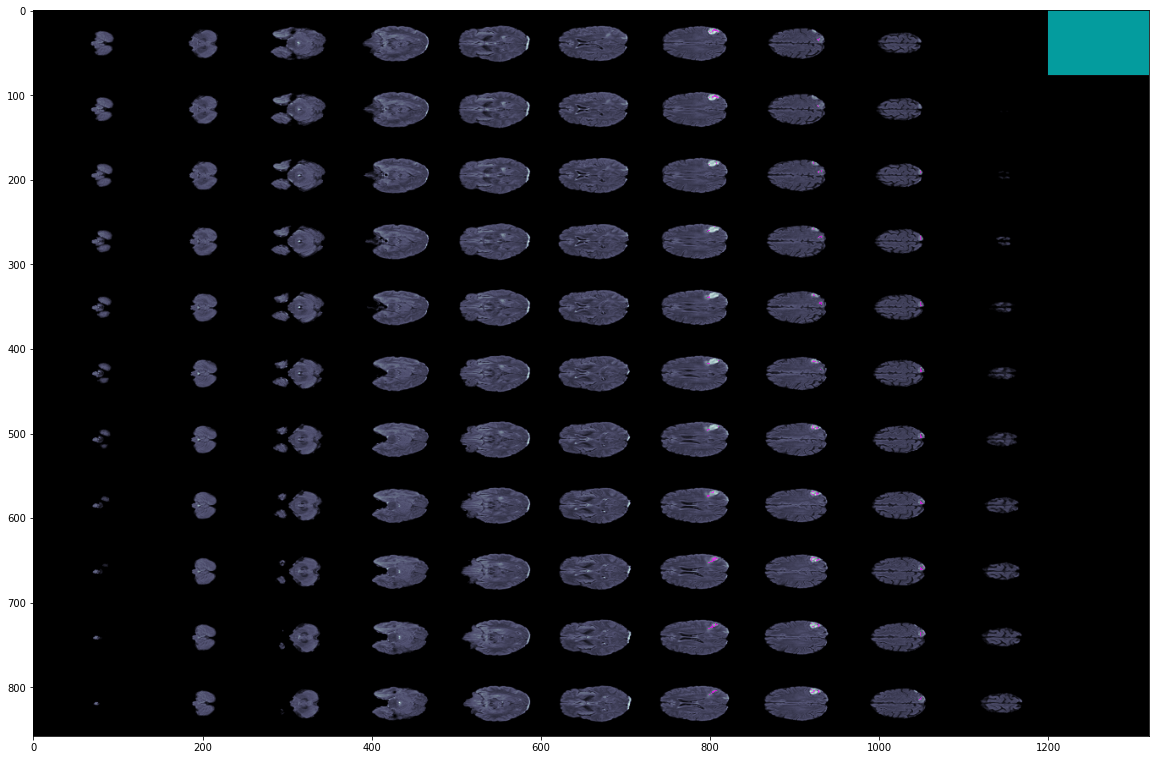

In [34]:
# dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0, is_resize=True)
dataloaders=trainer.dataloaders['train']
len(dataloader)
data = next(iter(dataloader))
print(data['Id'], data['image'].shape, data['mask'].shape)

tensor_3dimage = data['image'].squeeze()[0].cpu().detach().numpy() 
tensor_mask = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(tensor_3dimage, return_counts=True)[0]))
print("Min/Max Image values:", tensor_3dimage.min(), tensor_3dimage.max())
print("Num uniq Mask values:", np.unique(tensor_mask, return_counts=True))

image = np.rot90(montage(tensor_3dimage))
mask = np.rot90(montage(tensor_mask)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

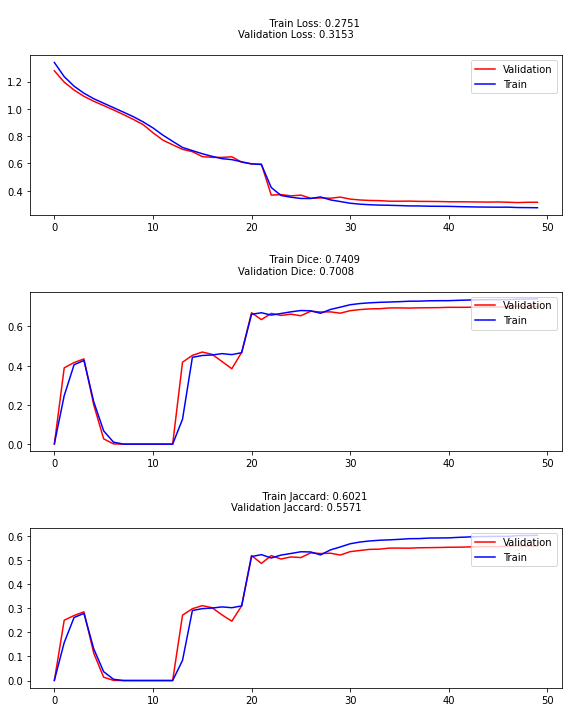


CPU times: user 1h 35min 21s, sys: 6min 6s, total: 1h 41min 27s
Wall time: 2h 33min


In [35]:
%%time
# CUDA_LAUNCH_BLOCKING=1.
trainer.run()

In [36]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes

In [37]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [38]:
model.eval();


In [45]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, val_dataloader, ['WT', 'TC', 'ET']
    )

CPU times: user 50.8 s, sys: 9.83 s, total: 1min
Wall time: 1min


In [40]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
4,0.691633,0.528623,0.547796,0.377217,2.895362e-14,2.895362e-14
9,0.786603,0.648265,0.465218,0.303117,9.176838e-14,9.176838e-14
27,0.577637,0.406111,0.752846,0.603651,3.226327e-14,3.226327e-14
2,0.687077,0.523318,0.742749,0.590772,2.825897e-14,2.825897e-14
20,0.700698,0.539288,0.113062,0.059918,8.257638e-13,8.257638e-13


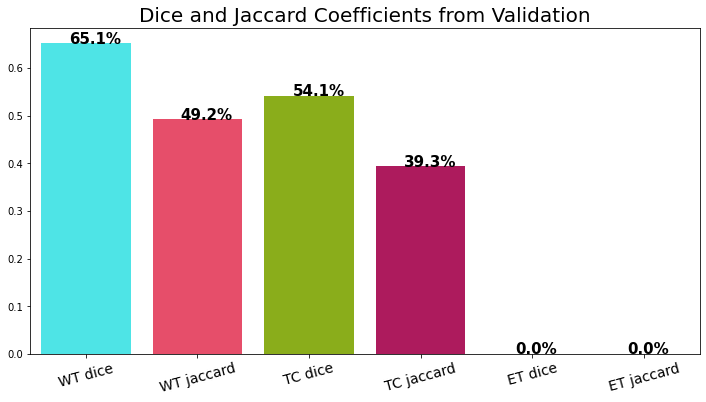

In [41]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [42]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 5):    
                return results
        return results


In [43]:
%%time
results = compute_results(
    model, val_dataloader, 0.33)

CPU times: user 9.76 s, sys: 3.32 s, total: 13.1 s
Wall time: 13.8 s


In [44]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):
    
    print(id_)
    break

['BraTS20_Training_003']


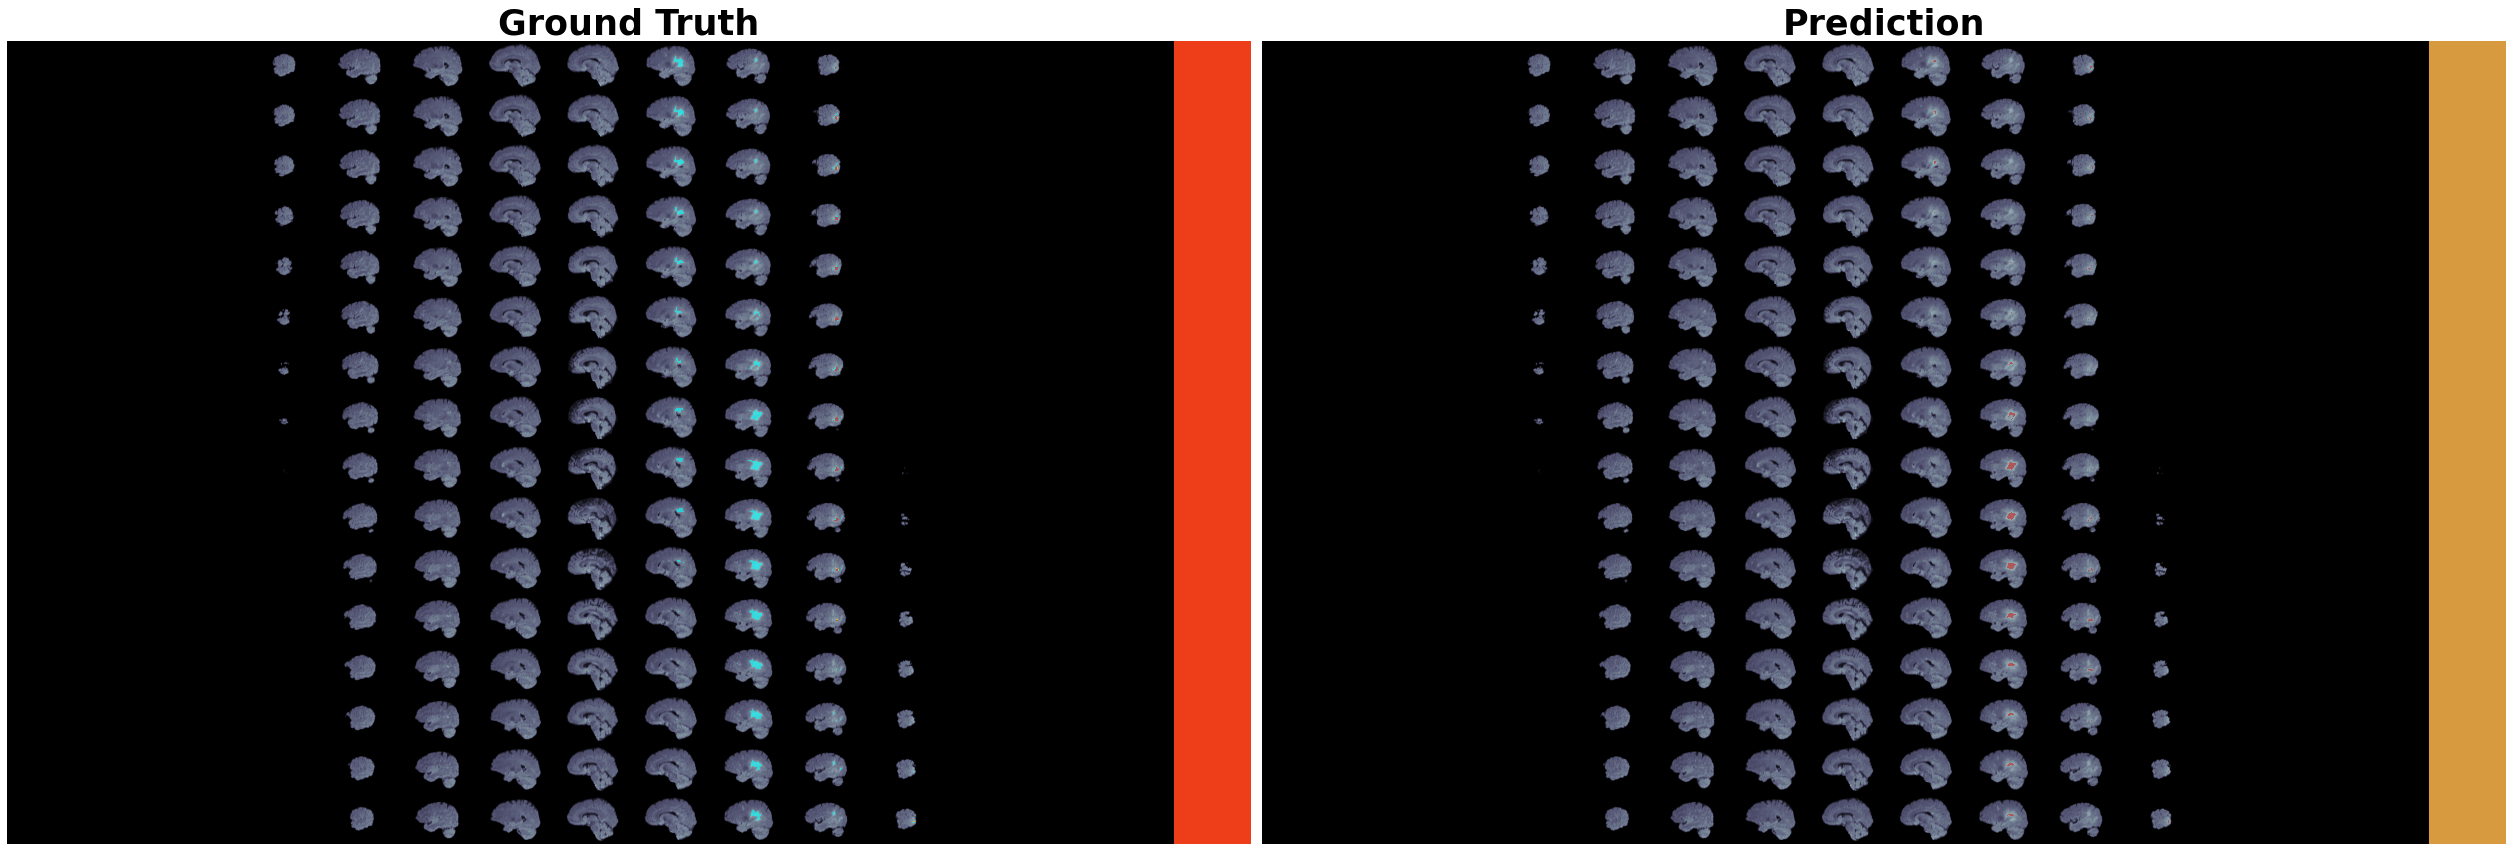

In [46]:
class ShowResult:
  
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
        
show_result = ShowResult()
show_result.plot(img, gt, prediction)

In [ ]:

# """ training one epoch and calculate loss and metrics """
# import sys
# # Training model
# #     model.train ()
# # torch.cuda.set_device(0)

# losses = 0.0
# accuracy = 0.0
# dice_scores = 0.0
# iou_scores = 0.0
# steps = len (loader)
# model=model.to(device)
# # LAUNCH_BLOCKING=1.
# for j in range(2):

#     for itr, data_batch in enumerate(loader):
#         images, targets = data_batch['image'], data_batch['mask']
#         print(images.shape)
#         print(targets.shape)
#         images = images.float ().to(device)
#         targets = targets.float ().to(device)

#         outputs = model(images)
        
#         print('================')
        
#         loss = loss_fn(outputs, targets)
# #         losses += loss.item()

#         # Backpropagation and update weights
#         optimizer.zero_grad ()
#         loss.backward ()
#         optimizer.step ()
        
# #       torch.cuda.empty_cache()


In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 4 * 4, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 4 * 4)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [ ]:
# device='cuda'
# torch.cuda.empty_cache()
# img=torch.zeros((104800, 1, 28, 28)).to(device)
# # with torch.no_grad(): 
# net = net.to(device)


In [ ]:
# out=net(img)
# out.shape

In [ ]:

# """ training one epoch and calculate loss and metrics """
# import sys
# # Training model
# #     model.train ()
# # torch.cuda.set_device(0)

# losses = 0.0
# accuracy = 0.0
# dice_scores = 0.0
# iou_scores = 0.0
# steps = len (loader)
# model=model.to(device)
# LAUNCH_BLOCKING=1.
# for j in range(2):

#     for itr, data_batch in enumerate(loader):
#         images, targets = data_batch['image'], data_batch['mask']
#         print(images.shape)
#         print(targets.shape)
#         images = images.float ().to(device)
#         targets = targets.float ().to(device)
#         outputs = model(images)
        
#         print('================')
        
#         targets=targets.to(device)
#         loss = loss_fn(outputs, targets)
#         losses += loss

#         # Backpropagation and update weights
#         optimizer.zero_grad ()
#         loss.backward ()
#         optimizer.step ()
        
# #       torch.cuda.empty_cache()


In [ ]:
# torch.cuda.empty_cache()
# import gc
# gc.collect()

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
